# Text Summarization
## —— Based on T5 (Text-To-Text Transfer Transformer)

T5框架将所有自然语言处理任务重构为统一的文本到文本格式。其输入和输出始终是文本字符串，这与BERT模型形成了鲜明对比，因为BERT类的模型的输入有一定的局限性。T5框架允许我们在任何自然语言处理任务上使用相同的模型、损失函数与超参数，这包括机器翻译、文本摘要、机器问答和分类任务。

T5框架是一个有效的迁移学习技术。在开源的网站上获取的T5框架是受到过预训练的，我们只需要对框架进行微调，就可以将其作为有效的模型投入到使用中。

在这里，我们将尝试使用T5框架，基于AutoDL云上服务器，使用训练集对模型进行微调，从而尝试实现文本摘要。

本次实验是在参阅了大量技术文档后编写的，并且还在实验过程中发现了一些在网络上编写技术文档的人的代码错误。在这里，我们提供可以运行与复现结果的代码。

Reference github repository: https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_summarization_wandb.ipynb

### 1. 调取必要模块 

In [1]:
# 基础模块
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from rouge import Rouge
from sklearn.model_selection import KFold
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate import meteor_score
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

# 基于Transformers架构的T5框架
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [2]:
# 这段代码的目的是在AutoDL云上服务器中开启加速
# 从而更快地获取来自HuggingFace的内容
# 选自AutoDL的帮助文档
# 个人建议在AutoDL的环境下运行，或直接不运行这段代码。否则可能出现错误。

"""
如果在载入模块时连接时间过长，可以启用这段代码
建议在AutoDL的环境下运行，或自行配置合适的环境
否则可能出现错误！
"""
# import subprocess
# import os
# 
# result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
# output = result.stdout
# for line in output.splitlines():
#     if '=' in line:
#         var, value = line.split('=', 1)
#         os.environ[var] = value

In [3]:
# 调用GPU
# 本人租用的服务器采用了具有2块GPU的RTX 4090
from torch import cuda
device = "cuda" if cuda.is_available() else "cpu"

print(device)

cuda


### 2. 自定义数据集
基于train.csv设计的自定义数据集，为后续神经网络的微调做准备。

In [4]:
class MedicalDataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        # tokenizer: 用于分词
        self.tokenizer = tokenizer
        # data: 存储数据
        self.data = dataframe
        # description的内容的长度
        self.source_len = source_len
        # diagnosis的内容的长度
        self.summ_len = summ_len
        # csv文件中description列的内容
        self.description = self.data.description
        # csv文件中diagnosis列的内容
        self.diagnosis = self.data.diagnosis

    # 返回数据的数量
    def __len__(self):
        return len(self.description)
    
    def __getitem__(self, index):
        # 如果文本中有多个连续空格
        # 则合并为一个空格
        diagnosis = str(self.diagnosis[index])
        diagnosis = ' '.join(diagnosis.split())
        description = str(self.description[index])
        description = ' '.join(description.split())
        # batch_encode_plus将文本转为模型可以处理的编码
        source = self.tokenizer.batch_encode_plus([description],
                                                  max_length = self.source_len,     # 指定编码后文本最大长度
                                                  padding = 'max_length',           # 填充使得每个文本长度相同
                                                  return_tensors = 'pt',            # 返回Pytorch的张量
                                                  truncation = True)                # 如果超过最大长度，需要截断
        target = self.tokenizer.batch_encode_plus([diagnosis],
                                                  max_length = self.summ_len,       # 指定编码后文本最大长度
                                                  padding = 'max_length',           # 填充使得每个文本长度相同
                                                  return_tensors = 'pt',            # 返回Pytorch的张量
                                                  truncation = True)                # 如果超过最大长度，需要截断
        
        # Pytorch中的squeeze函数移除大小为1的维度
        # 张量形状更紧凑
        # input_ids返回了编码后的文本的token IDs
        # attention_mask二进制掩码，表明哪些位置是填充，注意力机制不应放在填充位置
        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long),
            'source_mask': source_mask.to(dtype=torch.long),
            'target_ids': target_ids.to(dtype=torch.long)
        }

### 3. 编写训练函数
训练集会经过训练函数，从而达成模型的微调。

In [5]:
loss_array = []

def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _, data in enumerate(loader):
        y = data['target_ids'].to(device, dtype = torch.long)
        # 获取 y 的每一行，且不要最后一个标记
        # 用contiguous使张量连续
        y_ids = y[:, :-1].contiguous()
        # detach让labels不用参与梯度计算
        labels = y[:, 1:].clone().detach()
        # 填充位置对应的损失值设为-100
        # -100是Pytorch中的一个特殊值，计算损失时会忽略这些位置
        labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)
        
        outputs = model(input_ids = ids,
                        attention_mask = mask,
                        decoder_input_ids = y_ids,
                        labels = labels)
        loss = outputs[0]
        
        if _%10 == 0:
            loss_array.append(loss.item())
        if _%500 == 0:
            print(f'Epoch: {epoch + 1}, Loss: {loss.item()}')
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### 4. 编写验证函数

In [6]:
def validate(tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actual = []
    with torch.no_grad():
        for _, data in enumerate(loader):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)
            
            generated_ids = model.generate(input_ids = ids,
                                           attention_mask = mask,
                                           max_length = 150,
                                           # Beam Search的参数数量
                                           num_beams = 2,
                                           # 重复惩罚
                                           repetition_penalty = 2.5,
                                           # 长度惩罚
                                           length_penalty = 1.0,
                                           # 要求在遇到End of Sequence时停止
                                           # 若设置为False，会生成直到最大长度
                                           early_stopping = True)
            preds = [tokenizer.decode(g,
                                      skip_special_tokens = True,
                                      clean_up_tokenization_spaces = True) for g in generated_ids]
            
            target = [tokenizer.decode(t,
                                       skip_special_tokens = True,
                                       clean_up_tokenization_spaces = True) for t in y]
            
            if _%100 == 0:
                print(f"Completed {_}")
                
            predictions.extend(preds)
            actual.extend(target)
        return predictions, actual

### 5. 五折交叉验证训练模型

In [7]:
# 设定参数
TRAIN_BATCH_SIZE = 2 # 训练的批次大小
VALID_BATCH_SIZE = 2 # 测试的批次大小
TRAIN_EPOCHS = 3     # 训练的轮次数量
LEARNING_RATE = 1e-4 # 学习率
SEED = 42            # 随机种子
MAX_LEN = 512        # source_len
SUMMARY_LEN = 150    # summ_len

In [8]:
# 设置随机种子
torch.manual_seed(SEED)
np.random.seed(SEED)

# 可复现性
torch.backends.cudnn.deterministic = True

In [9]:
# Tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-base")

/root/miniconda3/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to us

In [10]:
# 导入数据
df = pd.read_csv("train.csv")
df = df[['description', 'diagnosis']]
print(df.head())

                                         description  \
0  14 108 28 30 15 13 294 29 20 18 23 21 25 32 16...   
1  22 12 1137 41 17 16 96 17 16 34 48 17 30 40 13...   
2  14 108 333 30 15 13 31 29 20 829 891 21 25 11 ...   
3  22 12 135 269 205 24 267 27 12 376 32 94 109 2...   
4  34 12 48 63 109 28 30 40 13 1038 52 43 23 21 5...   

                                           diagnosis  
0                               22 12 38 41 17 81 10  
1  66 75 80 116 17 81 16 33 81 16 33 24 122 370 1...  
2                        35 48 49 150 167 308 282 10  
3  14 49 123 55 86 57 54 40 138 124 26 105 133 13...  
4  34 12 48 1064 86 57 54 138 10 22 12 38 41 17 8...  


In [24]:
des_len_list = []
diag_len_list = []
des_list = df['description'].tolist()
diag_list = df['diagnosis'].tolist()
for i in range(len(des_list)):
    des_len_list.append(len(des_list[i].split()))
for i in range(len(diag_list)):
    diag_len_list.append(len(diag_list[i].split()))

des_len_list = np.array(des_len_list)
diag_len_list = np.array(diag_len_list)

In [28]:
# 使用 numpy.unique 函数统计每个值的出现次数
unique_des, counts_des = np.unique(des_len_list, return_counts=True)
unique_diag, counts_diag = np.unique(diag_len_list, return_counts=True)

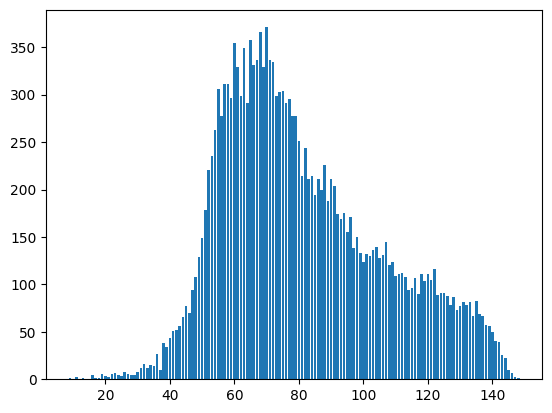

In [29]:
import matplotlib.pyplot as plt

plt.bar(unique_des, counts_des)
plt.show()

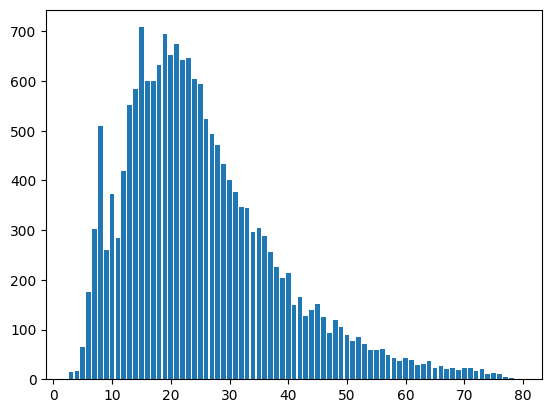

In [30]:
plt.bar(unique_diag, counts_diag)
plt.show()

In [17]:
# 定义参数
# num_workers = 0 表示在主进程中加载数据
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

val_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

In [14]:
# 正式开始训练
print("开始模型微调")

num = 1
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kfolds.split(df):
    des_trainset = df['description'][train_index]
    dia_trainset = df['diagnosis'][train_index]
    des_valset = df['description'][test_index]
    dia_valset = df['diagnosis'][test_index]
    train_dataset = pd.concat([des_trainset, dia_trainset], axis = 1).reset_index(drop = True)
    val_dataset = pd.concat([des_valset, dia_valset], axis = 1).reset_index(drop = True)
    
    training_set = MedicalDataset(train_dataset, tokenizer, MAX_LEN, SUMMARY_LEN)
    val_set = MedicalDataset(val_dataset, tokenizer, MAX_LEN, SUMMARY_LEN)
    
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)
    
    # 使用预训练的T5-base模型
    model = T5ForConditionalGeneration.from_pretrained("t5-base")
    model = model.to(device)
    
    # 定义优化器，使用Adam
    optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)
    
    for epoch in range(TRAIN_EPOCHS):
        train(epoch, tokenizer, model, device, training_loader, optimizer)
        
    print("在验证集上测试")

    predictions, actual = validate(tokenizer, model, device, val_loader)
    final_df = pd.DataFrame({'Generated Text':predictions, 'Actual Text':actual})
    final_df.to_csv('predictions' + str(num) + '.csv')
    num = num + 1
    
    print("输出文件已保存")

开始模型微调
Epoch: 1, Loss: 11.129202842712402
Epoch: 1, Loss: 1.6353784799575806
Epoch: 1, Loss: 1.9325711727142334
Epoch: 1, Loss: 2.706616163253784
Epoch: 1, Loss: 1.6612399816513062
Epoch: 1, Loss: 2.3715221881866455
Epoch: 1, Loss: 1.962568998336792
Epoch: 1, Loss: 2.006688117980957
Epoch: 1, Loss: 1.6987730264663696
Epoch: 1, Loss: 1.2478022575378418
Epoch: 1, Loss: 2.0609536170959473
Epoch: 1, Loss: 1.8287955522537231
Epoch: 1, Loss: 1.8780864477157593
Epoch: 1, Loss: 1.0878180265426636
Epoch: 1, Loss: 1.5201727151870728
Epoch: 2, Loss: 1.2881861925125122
Epoch: 2, Loss: 2.3111941814422607
Epoch: 2, Loss: 1.2189232110977173
Epoch: 2, Loss: 1.656742811203003
Epoch: 2, Loss: 0.5868077278137207
Epoch: 2, Loss: 1.3245850801467896
Epoch: 2, Loss: 1.4059505462646484
Epoch: 2, Loss: 1.352673053741455
Epoch: 2, Loss: 1.1126837730407715
Epoch: 2, Loss: 0.6306459903717041
Epoch: 2, Loss: 2.2962682247161865
Epoch: 2, Loss: 1.6262909173965454
Epoch: 2, Loss: 1.8107752799987793
Epoch: 2, Loss: 1.

### 6. 测试在验证集上的表现

In [7]:
for i in range(1, 6):
    df = pd.read_csv("predictions" + str(i) + ".csv")
    rouge1_p = 0
    rouge1_r = 0
    rouge1_f = 0
    rouge2_p = 0
    rouge2_r = 0
    rouge2_f = 0
    rougel_p = 0
    rougel_r = 0
    rougel_f = 0
    bleu_average = 0
    meteor_average = 0
    rouge = Rouge()
    for i in range(3600):
        answer = df["Actual Text"][i]
        summary = df["Generated Text"][i]
        scores = rouge.get_scores(summary, answer)
        rouge1_p += scores[0]["rouge-1"]["p"] / 3600
        rouge1_r += scores[0]["rouge-1"]["r"] / 3600
        rouge1_f += scores[0]["rouge-1"]["f"] / 3600
        rouge2_p += scores[0]["rouge-2"]["p"] / 3600
        rouge2_r += scores[0]["rouge-2"]["r"] / 3600
        rouge2_f += scores[0]["rouge-2"]["f"] / 3600
        rougel_p += scores[0]["rouge-l"]["p"] / 3600
        rougel_r += scores[0]["rouge-l"]["r"] / 3600
        rougel_f += scores[0]["rouge-l"]["f"] / 3600
        answer_nltk = [answer]
        bleu_average += sentence_bleu(answer_nltk, summary) / 3600
        summary_tokens = summary.split()
        answer_nltk_2 = [reference.split() for reference in answer_nltk]
        meteor_average += meteor_score.meteor_score(answer_nltk_2, summary_tokens) / 3600
    
    print("The precision of Rouge 1 is:", rouge1_p)
    print("The recall of Rouge 1 is:", rouge1_r)
    print("The F1 of Rouge 1 is:", rouge1_f)
    print("The precision of Rouge 2 is:", rouge2_p)
    print("The recall of Rouge 2 is:", rouge2_r)
    print("The F1 of Rouge 2 is:", rouge2_f)
    print("The precision of Rouge l is:", rougel_p)
    print("The recall of Rouge l is:", rougel_r)
    print("The F1 of Rouge l is:", rougel_f)
    print("BLEU Score:", bleu_average)
    print("METEOR Score:", meteor_average)
    print("----------------------------------------")

/root/miniconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/root/miniconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


The precision of Rouge 1 is: 0.6334480731977741
The recall of Rouge 1 is: 0.40595730433375243
The F1 of Rouge 1 is: 0.4617937761904676
The precision of Rouge 2 is: 0.4257467225280719
The recall of Rouge 2 is: 0.264591059370733
The F1 of Rouge 2 is: 0.30201917703403053
The precision of Rouge l is: 0.608457545769165
The recall of Rouge l is: 0.38856235331242617
The F1 of Rouge l is: 0.44240694041869805
BLEU Score: 0.3087068653929864
METEOR Score: 0.36785623411155066
----------------------------------------


/root/miniconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


The precision of Rouge 1 is: 0.6232592420832826
The recall of Rouge 1 is: 0.39922597180235314
The F1 of Rouge 1 is: 0.4572006003525956
The precision of Rouge 2 is: 0.41260488025463415
The recall of Rouge 2 is: 0.26208287902495403
The F1 of Rouge 2 is: 0.2986008440415351
The precision of Rouge l is: 0.5989009816036573
The recall of Rouge l is: 0.38396258345351525
The F1 of Rouge l is: 0.4394392798311479
BLEU Score: 0.3040686061047891
METEOR Score: 0.3613637419539785
----------------------------------------


/root/miniconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/root/miniconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


The precision of Rouge 1 is: 0.6232522432856581
The recall of Rouge 1 is: 0.41804190313072154
The F1 of Rouge 1 is: 0.4706128917756586
The precision of Rouge 2 is: 0.4185688900942835
The recall of Rouge 2 is: 0.2761733742501748
The F1 of Rouge 2 is: 0.30992189900090517
The precision of Rouge l is: 0.599036075572837
The recall of Rouge l is: 0.4022251072195083
The F1 of Rouge l is: 0.4525000908478149
BLEU Score: 0.32256216471783655
METEOR Score: 0.3799176032192976
----------------------------------------


/root/miniconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/root/miniconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


The precision of Rouge 1 is: 0.5925092249547469
The recall of Rouge 1 is: 0.36653600035386635
The F1 of Rouge 1 is: 0.42562978401640283
The precision of Rouge 2 is: 0.3963513013477084
The recall of Rouge 2 is: 0.23960691707123816
The F1 of Rouge 2 is: 0.2781478248607089
The precision of Rouge l is: 0.570837765758919
The recall of Rouge l is: 0.35278000354945943
The F1 of Rouge l is: 0.4096866142834225
BLEU Score: 0.27848973625025547
METEOR Score: 0.33129029008522565
----------------------------------------


/root/miniconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


The precision of Rouge 1 is: 0.6697403642362889
The recall of Rouge 1 is: 0.4015294132283951
The F1 of Rouge 1 is: 0.47357117915531466
The precision of Rouge 2 is: 0.45860917676685337
The recall of Rouge 2 is: 0.26291362740363133
The F1 of Rouge 2 is: 0.31211652989057825
The precision of Rouge l is: 0.646920304608545
The recall of Rouge l is: 0.3888074145063792
The F1 of Rouge l is: 0.4580273902010671
BLEU Score: 0.2907393866802122
METEOR Score: 0.3648656546467428
----------------------------------------


### 7. 使用全部训练集训练模型

In [18]:
# 导入数据
df = pd.read_csv("train.csv")
df = df[['description', 'diagnosis']]
print(df.head())

# 创建符合格式预期的数据集
training_set = MedicalDataset(df, tokenizer, MAX_LEN, SUMMARY_LEN)
training_loader = DataLoader(training_set, **train_params)

# 使用预训练的T5-base模型
model = T5ForConditionalGeneration.from_pretrained("t5-base")
model = model.to(device)

# 定义优化器，使用Adam
optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)

                                         description  \
0  14 108 28 30 15 13 294 29 20 18 23 21 25 32 16...   
1  22 12 1137 41 17 16 96 17 16 34 48 17 30 40 13...   
2  14 108 333 30 15 13 31 29 20 829 891 21 25 11 ...   
3  22 12 135 269 205 24 267 27 12 376 32 94 109 2...   
4  34 12 48 63 109 28 30 40 13 1038 52 43 23 21 5...   

                                           diagnosis  
0                               22 12 38 41 17 81 10  
1  66 75 80 116 17 81 16 33 81 16 33 24 122 370 1...  
2                        35 48 49 150 167 308 282 10  
3  14 49 123 55 86 57 54 40 138 124 26 105 133 13...  
4  34 12 48 1064 86 57 54 138 10 22 12 38 41 17 8...  


In [19]:
# 正式开始训练
print("开始模型微调")

for epoch in range(TRAIN_EPOCHS):
    train(epoch, tokenizer, model, device, training_loader, optimizer)

开始模型微调
Epoch: 1, Loss: 8.903597831726074
Epoch: 1, Loss: 2.116220474243164
Epoch: 1, Loss: 1.3851369619369507
Epoch: 1, Loss: 2.468543767929077
Epoch: 1, Loss: 1.5264686346054077
Epoch: 1, Loss: 1.843280553817749
Epoch: 1, Loss: 1.3375622034072876
Epoch: 1, Loss: 1.6534206867218018
Epoch: 1, Loss: 2.1570675373077393
Epoch: 1, Loss: 1.6730105876922607
Epoch: 1, Loss: 0.8825479745864868
Epoch: 1, Loss: 1.1177932024002075
Epoch: 1, Loss: 2.12724232673645
Epoch: 1, Loss: 2.3386847972869873
Epoch: 1, Loss: 0.8231897950172424
Epoch: 1, Loss: 1.0412274599075317
Epoch: 1, Loss: 1.471829891204834
Epoch: 1, Loss: 1.633987545967102
Epoch: 2, Loss: 1.2102771997451782
Epoch: 2, Loss: 1.8720906972885132
Epoch: 2, Loss: 1.6819136142730713
Epoch: 2, Loss: 0.971398115158081
Epoch: 2, Loss: 1.4370980262756348
Epoch: 2, Loss: 1.947583556175232
Epoch: 2, Loss: 1.7901825904846191
Epoch: 2, Loss: 1.3096225261688232
Epoch: 2, Loss: 1.7297186851501465
Epoch: 2, Loss: 0.9738976955413818
Epoch: 2, Loss: 1.89554

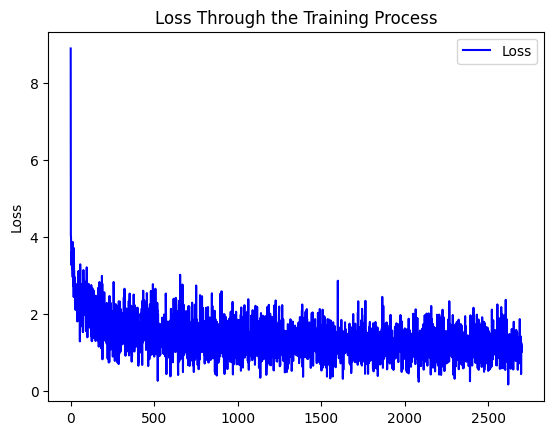

In [33]:
# 绘制损失函数曲线图
import matplotlib.pyplot as plt

# 创建 x 轴的坐标，这里使用列表的索引作为 x 轴坐标
x = list(range(1, len(loss_array) + 1))

plt.plot(x, loss_array, color='b', label='Loss')

plt.title('Loss Through the Training Process')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [32]:
df_test = pd.read_csv("test.csv")
val_dataset = df_test[['description', 'diagnosis']]
print(df_test.head())

val_set = MedicalDataset(val_dataset, tokenizer, MAX_LEN, SUMMARY_LEN)
val_loader = DataLoader(val_set, **val_params)

   index                                        description  \
0      0  185 185 185 185 22 12 116 71 64 694 40 13 146 ...   
1      1  14 281 28 30 15 13 20 18 23 21 25 10 14 32 101...   
2      2  34 12 129 373 27 160 181 75 100 31 29 92 177 1...   
3      3  22 12 48 16 85 63 109 28 16 74 914 64 56 40 13...   
4      4  35 12 163 63 103 63 12 142 13 45 52 139 195 21...   

                                           diagnosis  
0  22 12 74 71 823 56 91 208 73 14 198 209 14 426...  
1           34 12 49 167 57 92 11 117 118 316 441 10  
2  34 12 129 373 27 160 181 77 75 100 308 282 76 ...  
3  14 66 55 86 57 54 10 185 295 14 1236 208 14 19...  
4  227 185 35 12 163 63 16 103 63 14 190 57 76 24...  


In [22]:
print("在测试集上测试")

predictions, actual = validate(tokenizer, model, device, val_loader)
final_df = pd.DataFrame({'Generated Text':predictions, 'Actual Text':actual})
final_df.to_csv('predictions.csv')

print("输出文件已保存")

在测试集上测试
Completed 0
Completed 100
Completed 200
Completed 300
Completed 400
Completed 500
Completed 600
Completed 700
Completed 800
Completed 900
输出文件已保存


### 8. 评价在测试集上的表现

In [46]:
df = pd.read_csv("predictions.csv")
rouge1_p = 0
rouge1_r = 0
rouge1_f = 0
rouge2_p = 0
rouge2_r = 0
rouge2_f = 0
rougel_p = 0
rougel_r = 0
rougel_f = 0
bleu_average = 0
meteor_average = 0
rouge = Rouge()
for i in range(2000):
    answer = df["Actual Text"][i]
    summary = df["Generated Text"][i]
    scores = rouge.get_scores(summary, answer)
    rouge1_p += scores[0]["rouge-1"]["p"] / 2000
    rouge1_r += scores[0]["rouge-1"]["r"] / 2000
    rouge1_f += scores[0]["rouge-1"]["f"] / 2000
    rouge2_p += scores[0]["rouge-2"]["p"] / 2000
    rouge2_r += scores[0]["rouge-2"]["r"] / 2000
    rouge2_f += scores[0]["rouge-2"]["f"] / 2000
    rougel_p += scores[0]["rouge-l"]["p"] / 2000
    rougel_r += scores[0]["rouge-l"]["r"] / 2000
    rougel_f += scores[0]["rouge-l"]["f"] / 2000
    answer_nltk = [answer]
    bleu_average += sentence_bleu(answer_nltk, summary) / 2000
    summary_tokens = summary.split()
    answer_nltk_2 = [reference.split() for reference in answer_nltk]
    meteor_average += meteor_score.meteor_score(answer_nltk_2, summary_tokens) / 2000

print("The precision of Rouge 1 is:", rouge1_p)
print("The recall of Rouge 1 is:", rouge1_r)
print("The F1 of Rouge 1 is:", rouge1_f)
print("The precision of Rouge 2 is:", rouge2_p)
print("The recall of Rouge 2 is:", rouge2_r)
print("The F1 of Rouge 2 is:", rouge2_f)
print("The precision of Rouge l is:", rougel_p)
print("The recall of Rouge l is:", rougel_r)
print("The F1 of Rouge l is:", rougel_f)
print("BLEU Score:", bleu_average)
print("METEOR Score:", meteor_average)

/root/miniconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


The precision of Rouge 1 is: 0.6659794703595994
The recall of Rouge 1 is: 0.4036529011454539
The F1 of Rouge 1 is: 0.47196475167291824
The precision of Rouge 2 is: 0.46008146758608987
The recall of Rouge 2 is: 0.2718558631262256
The F1 of Rouge 2 is: 0.3175838082419594
The precision of Rouge l is: 0.6451009529071929
The recall of Rouge l is: 0.3915105995019245
The F1 of Rouge l is: 0.45753176984789845
BLEU Score: 0.3015368099454507
METEOR Score: 0.37053383966503006
